In [1]:
import json
import os

import dolfinx
import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import pyvista
import pyvista as pv
import pyvistaqt as pvqt
import ufl
import warnings

from dolfinx import cpp, default_scalar_type, fem, io, mesh, nls, plot
from dolfinx.fem import petsc
from dolfinx.io import gmshio, VTXWriter
from dolfinx.nls import petsc as petsc_nls
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from IPython.display import Image

from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 dot, div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, configs, geometry, utils

warnings.simplefilter('ignore')

In [2]:
!rm -r ~/.cache/fenics

In [3]:
Wa = 1e3
Wa_n = Wa
Wa_p = Wa
comm = MPI.COMM_WORLD
encoding = io.XDMFFile.Encoding.HDF5
micron = 1e-6
resolution = 1 * micron
kappa_elec = 0.1
kappa_pos_am = 0.2
name_of_study = "lithium_metal_3d_cc_2d"
dimensions = '150-500-0'
# dimensions = '75-40-0'
dimensions_ii = '10-65-10'
LX, LY, LZ = [float(vv) * micron for vv in dimensions.split("-")]
# meshdir = os.path.join(configs.get_configs()['LOCAL_PATHS']['data_dir'], name_of_study, dimensions, str(resolution))
meshdir = os.path.join(configs.get_configs()['LOCAL_PATHS']['data_dir'], name_of_study, dimensions, dimensions_ii, str(resolution))
workdir = os.path.join(meshdir, str(Wa_n) + "-" + str(Wa_p))
utils.make_dir_if_missing(meshdir)
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(meshdir, 'mesh.msh')
potential_resultsfile = os.path.join(workdir, "potential.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")
simulation_metafile = os.path.join(workdir, "simulation.json")

In [4]:
markers = commons.Markers()

## Binary Electrolyte - Nernst-Planck Equation

We make the following assumptions
- no bulk flow
- diffusivity not a function of concentration
- binary electrolyte

$$\frac{\partial c}{\partial t} + \pmb{v}\cdot\nabla c - D\nabla^2c=0$$

### [Electronic Conductivities](https://periodictable.com/Properties/A/ElectricalConductivity.an.html)
$$\sigma_{Li} = 1.1e7 \mathrm{\ S/m}$$
$$\sigma_{Cu} = 5.9e7 \mathrm{\ S/m}$$
$$\sigma_{Al} = 3.8e7 \mathrm{\ S/m}$$

#### Solid and Solution Parameters

From Chen 2020 *Journal of The Electrochemical Society, 2020 167 080534*, we can obtain parameters for use with our experiment. Here $c_e$ is concentration of $Li^+$ within the electrolyte in moles per cubic decimeter \[$\mathrm{mol}\cdot dm^{-3}$\].

Electronic conductivity of the electrolyte is given by:
$$\sigma_e = 0.1297c_e^3 - 2.51c_e^{1.5} + 3.329c_e$$

The diffusivity is given by:
$$D_e = 8.794 \cdot 10^{-11}c_e^2 - 3.972 \cdot 10^{-10}c_e + 4.862 \cdot 10^{-10}$$

The lithium ion transference number is given by:
$$t^+ = -0.1287c_e^3 + 0.4106c_e^2 - 0.4717c_e + 0.4492$$

Other parameters are given by

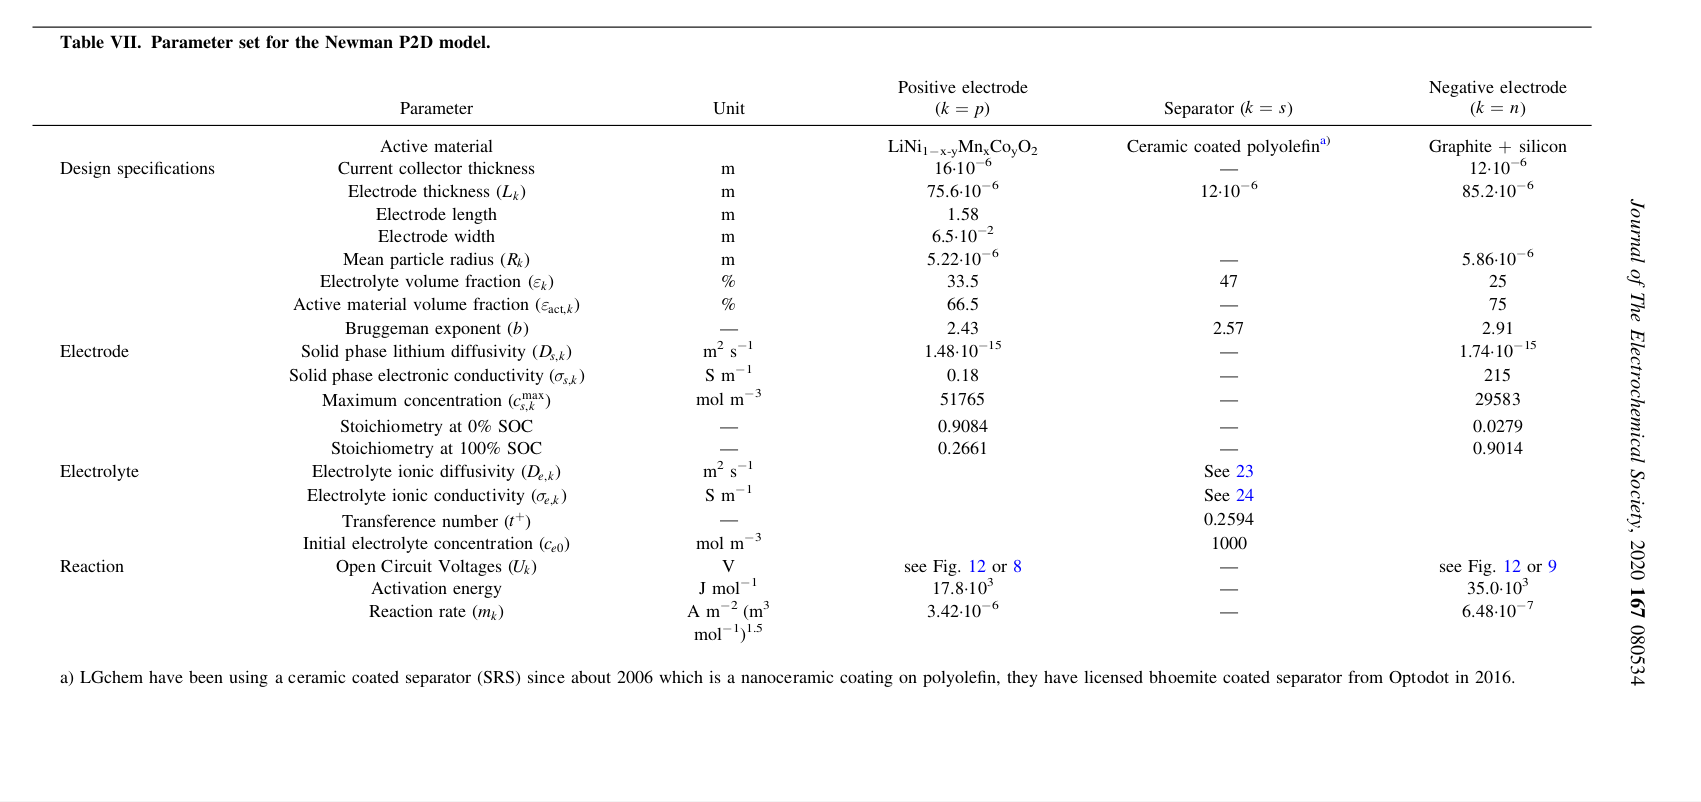

In [5]:
Image(filename="figures/chen-2020-table-vii.png")

### Read input geometry

In [6]:
# !python3 lmb_3d_cc_2d_geo.py

In [7]:
partitioner = mesh.create_cell_partitioner(mesh.GhostMode.shared_facet)
domain, ct, ft = gmshio.read_from_msh(output_meshfile, comm, partitioner=partitioner)
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)

ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

values[ft.indices] = ft.values
ft = mesh.meshtags(domain, fdim, indices, values)
ct = mesh.meshtags(domain, tdim, ct.indices, ct.values)
dx = ufl.Measure("dx", domain=domain, subdomain_data=ct)
ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
dS = ufl.Measure("dS", domain=domain, subdomain_data=ft)

Info    : Reading 'output/lithium_metal_3d_cc_2d/150-500-0/10-65-10/1e-06/mesh.msh'...
Info    : 415 entities
Info    : 68131 nodes
Info    : 139360 elements
Info    : Done reading 'output/lithium_metal_3d_cc_2d/150-500-0/10-65-10/1e-06/mesh.msh'


In [8]:
# full_mesh, cell_tags, facet_tags = dolfinx.io.gmshio.read_from_msh(output_meshfile, comm, 0)

# # Create submesh for pe
# # domain, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(full_mesh, full_mesh.topology.dim, cell_tags.indices[(cell_tags.values == markers.electrolyte)])
# domain, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(full_mesh, full_mesh.topology.dim, cell_tags.indices[np.logical_or(cell_tags.values == markers.electrolyte, cell_tags.values == markers.positive_am)])

# # Transfer facet tags from parent mesh to submesh
# tdim = full_mesh.topology.dim
# fdim = tdim - 1
# c_to_f = full_mesh.topology.connectivity(tdim, fdim)
# f_map = full_mesh.topology.index_map(fdim)
# all_facets = f_map.size_local + f_map.num_ghosts
# all_values = np.zeros(all_facets, dtype=np.int32)
# all_values[facet_tags.indices] = facet_tags.values

# domain.topology.create_entities(fdim)
# subf_map = domain.topology.index_map(fdim)
# domain.topology.create_connectivity(tdim, fdim)
# c_to_f_sub = domain.topology.connectivity(tdim, fdim)
# num_sub_facets = subf_map.size_local + subf_map.num_ghosts
# sub_values = np.empty(num_sub_facets, dtype=np.int32)
# for i, entity in enumerate(entity_map):
#     parent_facets = c_to_f.links(entity)
#     child_facets = c_to_f_sub.links(i)
#     for child, parent in zip(child_facets, parent_facets):
#         sub_values[child] = all_values[parent]

# ft = dolfinx.mesh.meshtags(domain, domain.topology.dim - 1, np.arange(
#     num_sub_facets, dtype=np.int32), sub_values)
# domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)
# ft_imap = domain.topology.index_map(fdim)
# num_facets = ft_imap.size_local + ft_imap.num_ghosts
# indices = np.arange(0, num_facets)
# values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

# values[ft.indices] = ft.values
# ft = mesh.meshtags(domain, fdim, indices, values)

# dx = ufl.Measure("dx", domain=domain)
# ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
# dS = ufl.Measure("dS", domain=domain, subdomain_data=ft)

### Function Spaces
#### conductivity $\kappa$ values varying in each domain

In [9]:
V = fem.FunctionSpace(domain, ("DG", 1))
W = fem.functionspace(domain, ("CG", 1, (3,)))
Q = fem.FunctionSpace(domain, ("DG", 0))
u = fem.Function(V, name='potential')
v = ufl.TestFunction(V)
current_h = fem.Function(W, name='current_density')
kappa = fem.Function(Q, name='conductivity')

n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)
h = ufl.CellDiameter(domain)
h_avg = avg(h)

cells_elec = ct.find(markers.electrolyte)
kappa.x.array[cells_elec] = np.full_like(cells_elec, kappa_elec, dtype=default_scalar_type)

cells_pos_am = ct.find(markers.positive_am)
kappa.x.array[cells_pos_am] = np.full_like(cells_pos_am, kappa_pos_am, dtype=default_scalar_type)

In [10]:
x = SpatialCoordinate(domain)

f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))

voltage = 1.0
u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(voltage)

In [11]:
faraday_const = fem.Constant(domain, PETSc.ScalarType(96485))
R = fem.Constant(domain, PETSc.ScalarType(8.3145))
T = fem.Constant(domain, PETSc.ScalarType(298))
i0 = fem.Constant(domain, PETSc.ScalarType(kappa_elec * R * T / (Wa * faraday_const * LX)))
i0_n = fem.Constant(domain, PETSc.ScalarType(kappa_elec * R * T / (Wa_n * faraday_const * LX)))
i0_p = fem.Constant(domain, PETSc.ScalarType(kappa_elec * R * T / (Wa_p * faraday_const * LX)))
Id = ufl.Identity(3)
def ocv(sod, L=1, k=2):
    return 2.5 + (1/k) * np.log((L - sod) / sod)
sod = 0.975

U_n = 0
U_vec = ufl.as_vector((0, 0, 0))
# U_p = ufl.as_vector((ocv(sod), ocv(sod), ocv(sod)))
U_p = ufl.as_vector((0, 0, 0))
V_left = 0

In [12]:
# alpha = 10
# γ = 10
# γ_factor = 1000

# F = kappa * inner(grad(u), grad(v)) * dx - f * v * dx - kappa * inner(grad(u), n) * v * ds

# # Add DG/IP terms
# F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(0)
# F += - inner(jump(kappa * u, n), avg(grad(v))) * dS(0)
# F += - inner(avg(kappa * grad(u)), jump(v, n)) * dS(0)
# F += + avg(u) * inner(jump(kappa, n), avg(grad(v))) * dS(0)
# F += alpha / h_avg * inner(jump(v, n), jump(u, n)) * dS(0)

# # Internal boundary
# F += - avg(kappa) * dot(avg(grad(v)), (R * T / i0 / faraday_const) * (kappa * grad(u))('+') + U) * dS(markers.negative_cc_v_negative_am)
# F += (alpha / h_avg) * avg(kappa) * dot(jump(v, n), (R * T / i0 / faraday_const) * (kappa * grad(u))('+') + U) * dS(markers.negative_cc_v_negative_am)

# # # Symmetry
# F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(markers.negative_cc_v_negative_am)

# # # Coercivity
# F += alpha / h_avg * avg(kappa) * inner(jump(u, n), jump(v, n)) * dS(markers.negative_cc_v_negative_am)

# # Nitsche Dirichlet BC terms on left and right boundaries
# F += - kappa * (u - u_left) * inner(n, grad(v)) * ds(markers.left)
# F += γ / h * (u - u_left) * v * ds(markers.left)
# F += - kappa * (u - u_right) * inner(n, grad(v)) * ds(markers.right) 
# F += γ / h * (u - u_right) * v * ds(markers.right)

# # Nitsche Neumann BC terms on insulated boundary
# F += -g * v * ds(markers.insulated_electrolyte) + γ * h * g * inner(grad(v), n) * ds(markers.insulated_electrolyte)
# F += - γ * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_electrolyte)
# F += -g * v * ds(markers.insulated_negative_cc) + γ_factor * γ * h * g * inner(grad(v), n) * ds(markers.insulated_negative_cc)
# F += - γ_factor * γ * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_negative_cc)

### Discontinuous Galerkin

In [13]:
alpha = 10
γ = alpha

F = kappa * inner(grad(u), grad(v)) * dx 
F -= + f * v * dx 
F += - kappa * inner(grad(u), n) * v * ds

# Add DG/IP terms
# F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(0)
F += - inner(jump(kappa * u, n), avg(grad(v))) * dS(0)
F += - inner(avg(kappa * grad(u)), jump(v, n)) * dS(0)
# F += + avg(u) * inner(jump(kappa, n), avg(grad(v))) * dS(0)
F += alpha / h_avg * inner(jump(v, n), jump(kappa * u, n)) * dS(0)

# left boundary - dirichlet
# F += - kappa * (u - u_left) * inner(n, grad(v)) * ds(markers.left)
# F += γ / h * (u - u_left) * v * ds(markers.left)

# charge xfer internal boundary - neumann
F += - inner(avg(grad(v)), U_p - R * T / i0 / faraday_const * (kappa * grad(u))('+')) * dS(markers.electrolyte_v_positive_am)
F += + alpha / h_avg * inner(jump(v, n), U_p - (R * T / i0_p / faraday_const) * (kappa * grad(u))('-')) * dS(markers.electrolyte_v_positive_am)
F += - inner(avg(grad(v)), U_p - R * T / i0 / faraday_const * (kappa * grad(u))('+')) * dS(markers.electrolyte_v_positive_am)
F += + alpha / h_avg * inner(jump(v, n), U_p - (R * T / i0_p / faraday_const) * (kappa * grad(u))('-')) * dS(markers.electrolyte_v_positive_am)

# charge transfer terms
# F += - dot(avg(grad(v)), (R * T / i0 / faraday_const) * (kappa * grad(u))('+') + U_p) * dS(markers.electrolyte_v_positive_am)
# F += alpha / h_avg * dot(jump(v, n), (R * T / i0_p / faraday_const) * (kappa * grad(u))('+') + U_p) * dS(markers.electrolyte_v_positive_am)
# F += - dot(avg(grad(v)), (R * T / i0 / faraday_const) * (kappa * grad(u))('-') + U_p) * dS(markers.electrolyte_v_positive_am)
# F += alpha / h_avg * dot(jump(v, n), (R * T / i0_p / faraday_const) * (kappa * grad(u))('-') + U_p) * dS(markers.electrolyte_v_positive_am)

# charge xfer internal boundary - symmetry
F += - inner(jump(kappa * u, n), avg(grad(v))) * dS(markers.electrolyte_v_positive_am)

# charge xfer internal boundary - coercivity
F += + alpha / h_avg * inner(jump(kappa * u, n), jump(v, n)) * dS(markers.electrolyte_v_positive_am)


# right boundary - dirichlet
F += - kappa * (u - u_right) * inner(n, grad(v)) * ds(markers.right) 
F += 1 / γ / h * (u - u_right) * v * ds(markers.right)

# insulated boundary - neumann
F += - γ * h * inner(inner(kappa * grad(u), n), inner(grad(v), n)) * ds(markers.insulated_electrolyte)
F -= + γ * h * g * inner(grad(v), n) * ds(markers.insulated_electrolyte)

# insulated boundary - neumann
F += - γ * h * inner(inner(kappa * grad(u), n), inner(grad(v), n)) * ds(markers.insulated_positive_am)
F -= + γ * h * g * inner(grad(v), n) * ds(markers.insulated_positive_am)

# kinetics boundary - neumann
F += - γ * h * inner(inner(kappa * grad(u), n), inner(grad(v), n)) * ds(markers.negative_cc_v_negative_am)
F -= - γ * h * i0_n * faraday_const / R / T * (V_left - u - U_n) * inner(grad(v), n) * ds(markers.negative_cc_v_negative_am)

# charge xfer external boundary - neumann
# F += - γ * h * inner(inner(kappa * grad(u), n), inner(grad(v), n)) * ds(markers.electrolyte_v_positive_am)
# F -= + γ * h * i0 * faraday_const / R / T  * (u - 0) * inner(grad(v), n) * ds(markers.electrolyte_v_positive_am)

problem = petsc.NonlinearProblem(F, u)
solver = petsc_nls.NewtonSolver(comm, problem)
solver.convergence_criterion = "residual"
solver.maximum_iterations = 25
solver.atol = 5e-11
solver.rtol = 1e-10
# print(solver.atol, solver.rtol)

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
# opts[f"{option_prefix}ksp_type"] = "gmres"
# opts[f"{option_prefix}pc_type"] = "chebyshev"

ksp.setFromOptions()
n_iters, converged = solver.solve(u)
if converged:
    current_expr = fem.Expression(-kappa * grad(u), W.element.interpolation_points())
    current_h.interpolate(current_expr)
    print(f"Converged in {n_iters} iterations")

Converged in 3 iterations


### Continuous Galerkin

In [14]:
# i_exchange = i0
# kappa = fem.Constant(domain, PETSc.ScalarType(kappa_elec))
# f = fem.Constant(domain, PETSc.ScalarType(0.0))
# g = fem.Constant(domain, PETSc.ScalarType(0.0))

# right_boundary = ft.find(markers.right)
# right_bc = fem.dirichletbc(u_right, fem.locate_dofs_topological(V, 1, right_boundary))

# F = ufl.inner(kappa * ufl.grad(u), ufl.grad(v)) * ufl.dx
# F += - ufl.inner(f, v) * ufl.dx + ufl.inner(g, v) * ds(markers.insulated_electrolyte) 
# F += + ufl.inner(i_exchange * faraday_const * (u - 0) / (R * T), v) * ds(markers.negative_cc_v_negative_am)

# problem = petsc.NonlinearProblem(F, u, bcs=[right_bc])
# solver = petsc_nls.NewtonSolver(comm, problem)
# solver.convergence_criterion = "residual"
# solver.maximum_iterations = 100
# solver.atol = np.finfo(float).eps
# solver.rtol = np.finfo(float).eps * 10

# ksp = solver.krylov_solver
# opts = PETSc.Options()
# option_prefix = ksp.getOptionsPrefix()
# opts[f"{option_prefix}ksp_type"] = "gmres"
# opts[f"{option_prefix}pc_type"] = "hypre"
# ksp.setFromOptions()
# n_iters, converged = solver.solve(u)
# if not converged:
#     print(f"Solver did not converge in {n_iters} iterations")
# else:
#     print(f"Converged in {n_iters} iterations")
# u.name = 'potential'
# u.x.scatter_forward()

In [15]:
with VTXWriter(comm, potential_resultsfile, [u], engine="BP4") as vtx:
    vtx.write(0.0)

with VTXWriter(comm, current_resultsfile, [current_h], engine="BP4") as vtx:
    vtx.write(0.0)

I_neg_charge_xfer = domain.comm.allreduce(fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.negative_cc_v_negative_am))), op=MPI.SUM)
I_pos_charge_xfer = domain.comm.allreduce(fem.assemble_scalar(fem.form(i0_p * faraday_const / R / T * (u("+") - u("-") - U_p(0)) * dS(markers.electrolyte_v_positive_am))), op=MPI.SUM)
I_right = domain.comm.allreduce(fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.right))), op=MPI.SUM)
I_insulated_elec = domain.comm.allreduce(fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_electrolyte))), op=MPI.SUM)
I_insulated_pos_am = domain.comm.allreduce(fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_positive_am))), op=MPI.SUM)
I_insulated = I_insulated_elec + I_insulated_pos_am
area_left = domain.comm.allreduce(fem.assemble_scalar(fem.form(1.0 * ds(markers.left))), op=MPI.SUM)
area_neg_charge_xfer = domain.comm.allreduce(fem.assemble_scalar(fem.form(1.0 * ds(markers.negative_cc_v_negative_am))), op=MPI.SUM)
area_pos_charge_xfer = domain.comm.allreduce(fem.assemble_scalar(fem.form(1.0 * dS(markers.electrolyte_v_positive_am))), op=MPI.SUM)
area_right = domain.comm.allreduce(fem.assemble_scalar(fem.form(1.0 * ds(markers.right))), op=MPI.SUM)
i_sup_left = np.abs(I_neg_charge_xfer / area_neg_charge_xfer)
i_sup = np.abs(I_right / area_right)
eta = np.abs(i_sup_left) * (Wa  * LX / kappa_elec)
eta_p = 0#domain.comm.allreduce(fem.assemble_scalar(fem.form(np.abs((u("+") - u("-") - U_p(0))) * dS(markers.electrolyte_v_positive_am))), op=MPI.SUM) / area_pos_charge_xfer
print(f"{area_neg_charge_xfer / area_right:.2f}, {area_pos_charge_xfer / area_right:.2f}")
simulation_metadata = {
    "Negative Overpotential [V]": eta,
    "Positive Overpotential [V]": eta_p,
    "Voltage": voltage,
    "dimensions": dimensions,
    "i_sup [A/m2]": f"{np.abs(i_sup):.2e} [A/m2]",
    "Current at negative am - electrolyte boundary": f"{np.abs(I_neg_charge_xfer):.2e} A",
    "Current at electrolyte - positive am boundary": f"{np.abs(I_pos_charge_xfer):.2e} A",
    "Current at right boundary": f"{np.abs(I_right):.2e} A",
    "Current at insulated boundary": f"{I_insulated:.2e} A",
}
print(f"Voltage: {voltage} [V]")
print(f"Negative Overpotential: {eta:.2e} [V]")
print(f"Positive Overpotential: {eta_p:.2e} [V]")
print(f"superficial current density @ left: {np.abs(i_sup_left):.2e} [A/m2]")
print(f"superficial current density @ right: {np.abs(i_sup):.2e} [A/m2]")
print(f"Current at negative_am - electrolyte boundary: {np.abs(I_neg_charge_xfer):.2e} A")
print(f"Current at electrolyte - positive am boundary: {np.abs(I_pos_charge_xfer):.2e} A")
print(f"Current at right boundary: {np.abs(I_right):.2e} A")
print(f"Current at insulated boundary: {I_insulated:.2e} A")
print(f"Float precision is {np.finfo(float).eps}")
with open(simulation_metafile, "w", encoding='utf-8') as f:
    json.dump(simulation_metadata, f, ensure_ascii=False, indent=4)

2.00, 7.50
Voltage: 1.0 [V]
Negative Overpotential: 1.74e-01 [V]
Positive Overpotential: 0.00e+00 [V]
superficial current density @ left: 1.16e-01 [A/m2]
superficial current density @ right: 2.59e-01 [A/m2]
Current at negative_am - electrolyte boundary: 1.16e-04 A
Current at electrolyte - positive am boundary: 1.14e-04 A
Current at right boundary: 1.30e-04 A
Current at insulated boundary: 7.17e-06 A
Float precision is 2.220446049250313e-16


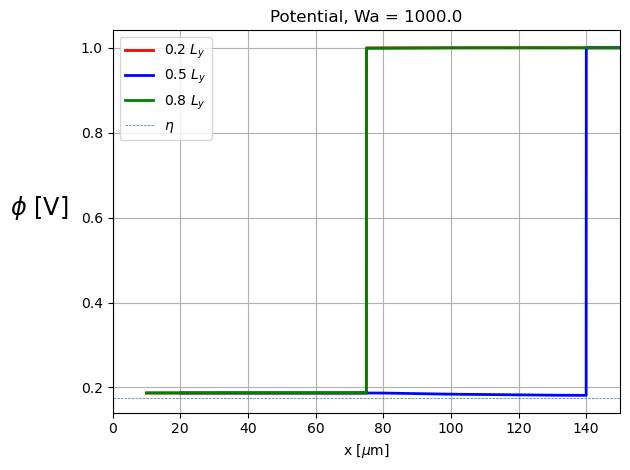

In [16]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-9  # Avoid hitting the outside of the domain

points = np.zeros((3, n_points))
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green']
for idx, frac in enumerate([0.2, 0.5, 0.8]):
    # if np.isclose(frac, 0.25) or np.isclose(frac, 0.75):
    #     x = np.linspace(10 * micron + tol, LX - tol, n_points)
    # else:
    x = np.linspace(0 + tol, LX - tol, n_points)
    points[0] = x
    y = np.ones(n_points) * frac * LY  # position
    points[1] = y
    u_values = []
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = compute_collisions_points(bb_trees, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    u_values = u.eval(points_on_proc, cells)
    ax.plot((1/micron) * points_on_proc[:, 0], u_values, "-", linewidth=2, label=f'{frac}' + r' $L_y$', color=colors[idx])
    ax.grid(True)
ax.set_xlim([0, LX/micron])
# ax.set_ylim([0, voltage])

ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel(r'$\mathrm{x}$ ' + '[$\mu$m]')
ax.axhline(y=eta, linestyle='--', linewidth=0.5, label=r'$\eta$')
ax.legend()
ax.set_title(f'Potential, Wa = {Wa}')
plt.tight_layout()
plt.savefig(os.path.join(workdir, 'potential-dist-midline.png'))
plt.show()

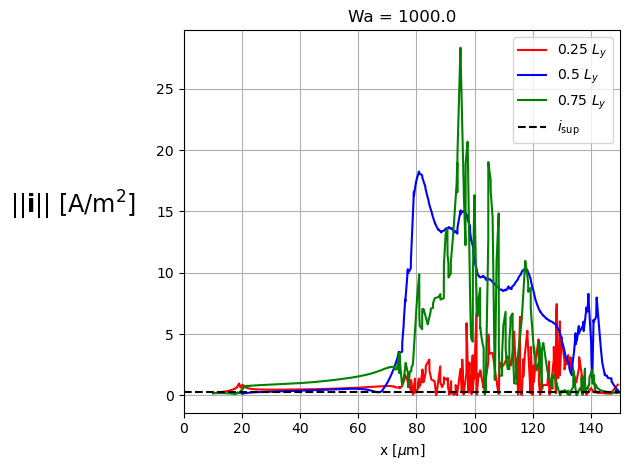

In [17]:
bb_trees = bb_tree(domain, domain.topology.dim)
points = np.zeros((3, n_points))
fig, ax = plt.subplots()
for idx, frac in enumerate([0.25, 0.5, 0.75]):
    if np.isclose(frac, 0.25, atol=1e-3) or np.isclose(frac, 0.75, atol=1e-3):
        x = np.linspace(10 * micron + tol, LX - tol, n_points)
    else:
        x = np.linspace(0 + tol, LX - tol, n_points)
    points[0] = x
    y = np.ones(n_points) * frac * LY
    points[1] = y
    u_values = []
    cells = []
    points_on_proc = []
    cell_candidates = compute_collisions_points(bb_trees, points.T)
    colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    current_values = current_h.eval(points_on_proc, cells)
    ax.plot((1/micron) * points_on_proc[:, 0], np.linalg.norm(current_values, axis=1), "-", linewidth=1.5, color=colors[idx], label=f'{frac}'+r' $L_y$')
ax.axhline(y=i_sup, color='black', linestyle='--', label=r'$i_{\mathrm{sup}}$')
ax.grid(True)
ax.legend()
ax.set_xlim([0, LX / micron])
ax.set_ylabel(r'||$\mathbf{i}$|| [A/m$^2$]', rotation=0, labelpad=60, fontsize='xx-large')
ax.set_xlabel(r'$\mathrm{x}$ ' + r'[$\mu$m]')
ax.set_title(f'Wa = {Wa}')
plt.tight_layout()
plt.savefig(os.path.join(workdir, 'current-dist-midline.png'))
plt.show()

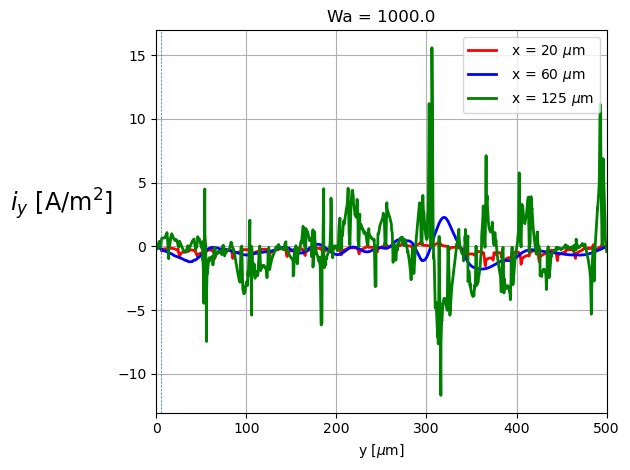

In [18]:
bb_trees = bb_tree(domain, domain.topology.dim)
points = np.zeros((3, n_points))
fig, ax = plt.subplots()
# fracs = [15e-6, 30e-6, 50e-6]
fracs = [20e-6, 60e-6, 125e-6]
for idx, frac in enumerate(fracs):
    y = np.linspace(0 + tol, LY - tol, n_points)
    points[1] = y
    x = np.ones(n_points) * frac
    points[0] = x
    u_values = []
    cells = []
    points_on_proc = []
    cell_candidates = compute_collisions_points(bb_trees, points.T)
    colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    current_values = current_h.eval(points_on_proc, cells)
    ax.plot((1/micron) * points_on_proc[:, 1], current_values[:, 1], "-", linewidth=2, color=colors[idx], label=r' $\mathrm{x}$ = ' + f'{int(frac/micron)} ' + r'$\mu$m')
ax.grid(True)
ax.legend()
# ax.set_xlim([0, 0.2 * LY / micron])
ax.set_xlim([0, LY / micron])
ax.set_ylabel(r'$i_y$ [A/m$^2$]', rotation=0, labelpad=40, fontsize='xx-large')
ax.set_xlabel(r'$\mathrm{y}$ ' + r'[$\mu$m]')
ax.axvline(x=5, linestyle='--', linewidth=0.5)
ax.set_title(f'Wa = {Wa}')
plt.tight_layout()
plt.savefig(os.path.join(workdir, 'current-dist-y-vertical.png'))
plt.show()

## Concentration Problem

In [19]:
# full_mesh, cell_tags, facet_tags = dolfinx.io.gmshio.read_from_msh(output_meshfile, comm, 0)

# # Create submesh for pe
# pam_domain, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(full_mesh, full_mesh.topology.dim, cell_tags.indices[(cell_tags.values == mrkr.electrolyte)])

# # Transfer facet tags from parent mesh to submesh
# tdim = full_mesh.topology.dim
# fdim = tdim - 1
# c_to_f = full_mesh.topology.connectivity(tdim, fdim)
# f_map = full_mesh.topology.index_map(fdim)
# all_facets = f_map.size_local + f_map.num_ghosts
# all_values = np.zeros(all_facets, dtype=np.int32)
# all_values[facet_tags.indices] = facet_tags.values

# pam_domain.topology.create_entities(fdim)
# subf_map = pam_domain.topology.index_map(fdim)
# pam_domain.topology.create_connectivity(tdim, fdim)
# c_to_f_sub = pam_domain.topology.connectivity(tdim, fdim)
# num_sub_facets = subf_map.size_local + subf_map.num_ghosts
# sub_values = np.empty(num_sub_facets, dtype=np.int32)
# for i, entity in enumerate(entity_map):
#     parent_facets = c_to_f.links(entity)
#     child_facets = c_to_f_sub.links(i)
#     for child, parent in zip(child_facets, parent_facets):
#         sub_values[child] = all_values[parent]
# sub_meshtag = dolfinx.mesh.meshtags(pam_domain, pam_domain.topology.dim - 1, np.arange(
#     num_sub_facets, dtype=np.int32), sub_values)
# pam_domain.topology.create_connectivity(pam_domain.topology.dim - 1, pam_domain.topology.dim)

# with dolfinx.io.XDMFFile(comm, "submesh.xdmf", "w", encoding=encoding) as xdmf:
#     xdmf.write_mesh(pam_domain)
#     xdmf.write_meshtags(sub_meshtag, x=pam_domain.geometry)

In [20]:
# c_init = 1000  # mol/m3
# t = 0 # Start time
# eps = 1e-15
# dt = 1e-6
# T = 500 * dt

# dx = ufl.Measure("dx", domain=pam_domain)
# ds = ufl.Measure("ds", domain=pam_domain, subdomain_data=sub_meshtag)
# dS = ufl.Measure("dS", domain=pam_domain, subdomain_data=sub_meshtag)
# n = ufl.FacetNormal(pam_domain)
# tdim = pam_domain.topology.dim
# fdim = tdim - 1

# # Create boundary condition
# # boundary_facets = sub_meshtag.find(mrkr['middle'])
# # bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(Q, fdim, boundary_facets), Q)

# Q = fem.FunctionSpace(pam_domain, ("CG", 1))
# c_n = fem.Function(Q)
# c_n.name = "c_n"
# c_n.interpolate(lambda x:  x[0] - x[0] + c_init)
# c_n.x.scatter_forward()

# potential = fem.Function(Q)
# padding = 1e-16
# u1_2_u2_nmm_data = \
#         fem.create_nonmatching_meshes_interpolation_data(
#             potential.function_space.mesh._cpp_object,
#             potential.function_space.element,
#             u_cg.function_space.mesh._cpp_object, padding=padding)

# potential.interpolate(u, nmm_interpolation_data=u1_2_u2_nmm_data)
# potential.x.scatter_forward()

# ch = fem.Function(Q)
# ch.name = "concentration"
# ch.interpolate(lambda x: x[0] - x[0] + c_init)
# ch.x.scatter_forward()

# c = ufl.TrialFunction(Q)
# q = ufl.TestFunction(Q)

# f = fem.Constant(pam_domain, PETSc.ScalarType(0))
# g = fem.Constant(pam_domain, PETSc.ScalarType(0))
# g_middle = fem.Constant(pam_domain, PETSc.ScalarType(0))
# D_bulk = 1e-2
# D = fem.Constant(pam_domain, PETSc.ScalarType(D_bulk))

# a = c * q * dx + dt * ufl.inner(D * ufl.grad(c), ufl.grad(q)) * dx
# L = (
#     (c_n + dt * f) * q * dx 
#     + dt * ufl.inner(g, q) * ds(mrkr.insulated_electrolyte) 
#     + dt * ufl.inner(g, q) * ds(mrkr.right)
#     + dt * ufl.inner(ufl.grad(potential) / 96485, n) * q * ds(mrkr.middle)
# )

# bilinear_form = fem.form(a)
# linear_form = fem.form(L)

# A = petsc.assemble_matrix(bilinear_form, bcs=[])
# A.assemble()
# b = fem.petsc.create_vector(linear_form)

# solver = PETSc.KSP().create(comm)
# solver.setOperators(A)
# solver.setType(PETSc.KSP.Type.PREONLY)
# solver.getPC().setType(PETSc.PC.Type.LU)

# c_vtx = VTXWriter(comm, concentration_resultsfile, [ch], engine="BP4")
# c_vtx.write(0.0)

# while t < T:
#     t += dt

#     A = fem.petsc.assemble_matrix(bilinear_form, bcs=[])
#     A.assemble()
#     solver.setOperators(A)

#     # Update the right hand side reusing the initial vector
#     with b.localForm() as loc_b:
#         loc_b.set(0)
#     fem.petsc.assemble_vector(b, linear_form)

#     # Apply Dirichlet boundary condition to the vector
#     fem.petsc.apply_lifting(b, [bilinear_form], [[]])
#     b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
#     fem.petsc.set_bc(b, [])

#     # Solve linear problem
#     solver.solve(b, ch.vector)
#     ch.x.scatter_forward()
#     # c_avg = fem.assemble_scalar(fem.form(ch * dx)) / fem.assemble_scalar(fem.form(1 * dx))
#     # print(f"average concentration: {c_avg}")

#     # Update solution at previous time step (c_n)
#     if np.any(ch.x.array < 0):
#         print(f"Lithium depletion at {t:.2e} seconds")
#         break
#     if np.any(ch.x.array == np.inf):
#         print(f"diverged at {t:.2e} seconds")
#         break
#     c_n.x.array[:] = ch.x.array
#     c_vtx.write(t)
# c_vtx.close()

In [21]:
# visualization
# bb_trees = bb_tree(pam_domain, pam_domain.topology.dim)
# n_points = 10000
# tol = 1e-8  # Avoid hitting the outside of the domain

# # midline in 2D
# x = np.linspace(0 + tol, 45e-6 - tol, n_points)
# y = np.ones(n_points) * 0.5 * 30e-6  # midline

# points = np.zeros((3, n_points))
# points[0] = x
# points[1] = y
# u_values = []
# cells = []
# points_on_proc = []
# # Find cells whose bounding-box collide with the the points
# cell_candidates = compute_collisions_points(bb_trees, points.T)
# # Choose one of the cells that contains the point
# colliding_cells = compute_colliding_cells(pam_domain, cell_candidates, points.T)
# for i, point in enumerate(points.T):
#     if len(colliding_cells.links(i)) > 0:
#         points_on_proc.append(point)
#         cells.append(colliding_cells.links(i)[0])
# points_on_proc = np.array(points_on_proc, dtype=np.float64)
# u_values = ch.eval(points_on_proc, cells)
# fig, ax = plt.subplots()
# ax.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
# ax.grid(True)
# ax.set_xlim([0, 45e-6])
# # ax.set_ylim([0, c_init])
# ax.set_ylabel(r'$c$ [mol/m$^3$]', rotation=0, labelpad=50, fontsize='xx-large');
# ax.set_xlabel('[m]');
# ax.set_title(f't = {t:.1e} s, and D = {D_bulk:.1e} ' + r'm$^{2}$s$^{-1}$');
# plt.tight_layout();
# plt.savefig(f'figures/lma-concentration-{D_bulk:.2e}.png', dpi=1500);